In [1]:
import os
import numpy as np
import random
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from math import floor
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dense, AveragePooling2D, GaussianNoise
from tensorflow.keras.layers import Reshape, UpSampling2D, Activation, Dropout, Flatten, Conv2DTranspose
from tensorflow.keras.models import model_from_json, Sequential
from tensorflow.keras.optimizers import Adam
import cv2
import skimage
from skimage import io
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
import pandas as pd
from PIL import ImageFilter


## Define GAN

In [2]:
def zero():
    return np.random.uniform(0.0, 0.01, size = [1])

def one():
    return np.random.uniform(0.99, 1.0, size = [1])

def noise(n):
    return np.random.uniform(-1.0, 1.0, size = [n, 4096])
   
    
class GAN(object):
    
    def __init__(self):
        
        #Models
        self.D = None
        self.G = None
        
        self.OD = None
        
        self.DM = None
        self.AM = None
        
        #Config
        self.LR = 0.0001
        self.steps = 1
        
    def discriminator(self):
        
        if self.D:
            return self.D
        
        self.D = Sequential()
        
        #add Gaussian noise to prevent Discriminator overfitting
        self.D.add(GaussianNoise(0.2, input_shape = [256, 256, 3]))
        
        #256x256x3 Image
        self.D.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #128x128x8
        self.D.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #64x64x16
        self.D.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #32x32x32
        self.D.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #16x16x64
        self.D.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #8x8x128
        self.D.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #4x4x256
        self.D.add(Flatten())
        
        #256
        self.D.add(Dense(128))
        self.D.add(LeakyReLU(0.2))
        
        self.D.add(Dense(1, activation = 'sigmoid'))
        
        return self.D
    
    def generator(self):
        
        if self.G:
            return self.G
        
        self.G = Sequential()
        
        self.G.add(Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))
        
        #1x1x4096 
        self.G.add(Conv2DTranspose(filters = 256, kernel_size = 4))
        self.G.add(Activation('relu'))
        
        #4x4x256 - kernel sized increased by 1
        self.G.add(Conv2D(filters = 256, kernel_size = 4, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #8x8x256 - kernel sized increased by 1
        self.G.add(Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #16x16x128
        self.G.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #32x32x64
        self.G.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #64x64x32
        self.G.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #128x128x16
        self.G.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #256x256x8
        self.G.add(Conv2D(filters = 3, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('sigmoid'))
        
        return self.G
    
    def DisModel(self):
        
        if self.DM == None:
            self.DM = Sequential()
            self.DM.add(self.discriminator())
        
        self.DM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.DM
    
    def AdModel(self):
        
        if self.AM == None:
            self.AM = Sequential()
            self.AM.add(self.generator())
            self.AM.add(self.discriminator())
            
        self.AM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.AM
    
    def sod(self):
        
        self.OD = self.D.get_weights()
        
    def lod(self):
        
        self.D.set_weights(self.OD)



class Model_GAN(object):
    
    def __init__(self):
        
        self.GAN = GAN()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        self.generator = self.GAN.generator()
        
    def train(self, batch = 16):
        
        (a, b) = self.train_dis(batch)
        c = self.train_gen(batch)
        
        print(f"D Real: {str(a)}, D Fake: {str(b)}, G All: {str(c)}")
        
        if self.GAN.steps % 500 == 0:
            self.save(floor(self.GAN.steps / 1000))
            self.evaluate()
            
        if self.GAN.steps % 5000 == 0:
            self.GAN.AM = None
            self.GAN.DM = None
            self.AdModel = self.GAN.AdModel()
            self.DisModel = self.GAN.DisModel()
        
        self.GAN.steps = self.GAN.steps + 1
        
    def train_dis(self, batch):
        
        #Get Real Images
        im_no = random.randint(0, len(Images) - batch - 1)
        train_data = Images[im_no : im_no + int(batch / 2)]
        label_data = []
        for i in range(int(batch / 2)):
            #label_data.append(one())
            label_data.append(zero())
            
        d_loss_real = self.DisModel.train_on_batch(np.array(train_data), np.array(label_data))
        
        #Get Fake Images
        train_data = self.generator.predict(noise(int(batch / 2)))
        label_data = []
        for i in range(int(batch / 2)):
            #label_data.append(zero())
            label_data.append(one())
            
        d_loss_fake = self.DisModel.train_on_batch(train_data, np.array(label_data))
        
        return (d_loss_real, d_loss_fake)
        
    def train_gen(self, batch):
        
        self.GAN.sod()
        
        label_data = []
        for i in range(int(batch)):
            #label_data.append(one())
            label_data.append(zero())
        
        g_loss = self.AdModel.train_on_batch(noise(batch), np.array(label_data))
        
        self.GAN.lod()
        
        return g_loss
        
    def evaluate(self):
        
        im_no = random.randint(0, len(Images) - 1)
        im1 = Images[im_no]
        
        im2 = self.generator.predict(noise(2))
        
        plt.figure(1)
        plt.imshow(im1)
        
        plt.figure(2)
        plt.imshow(im2[0])
        
        plt.figure(3)
        plt.imshow(im2[1])
        
        plt.show()
        
    def save(self, num):
        gen_json = self.GAN.G.to_json()
        dis_json = self.GAN.D.to_json()

        with open("Models/gen.json", "w+") as json_file:
            json_file.write(gen_json)

        with open("Models/dis.json", "w+") as json_file:
            json_file.write(dis_json)

        self.GAN.G.save_weights("Models/gen"+str(num)+".h5")
        self.GAN.D.save_weights("Models/dis"+str(num)+".h5")

        print(f"Model number {str(num)} Saved!")

    def load(self, num, folder):
        steps1 = self.GAN.steps
        
        self.GAN = None
        self.GAN = GAN()

        #Generator
        gen_file = open(f"Models/{folder}/gen.json", 'r')
        gen_json = gen_file.read()
        gen_file.close()
        
        self.GAN.G = model_from_json(gen_json)
        self.GAN.G.load_weights(f"Models/{folder}/gen"+str(num)+".h5")

        #Discriminator
        dis_file = open(f"Models/{folder}/dis.json", 'r')
        dis_json = dis_file.read()
        dis_file.close()
        
        self.GAN.D = model_from_json(dis_json)
        self.GAN.D.load_weights(f"Models/{folder}/dis"+str(num)+".h5")

        #Reinitialize
        self.generator = self.GAN.generator()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        
        self.GAN.steps = steps1
        
    def eval2(self, num = 0):
        
        im2 = self.generator.predict(noise(48))
        
        r1 = np.concatenate(im2[:8], axis = 1)
        r2 = np.concatenate(im2[8:16], axis = 1)
        r3 = np.concatenate(im2[16:24], axis = 1)
        r4 = np.concatenate(im2[24:32], axis = 1)
        r5 = np.concatenate(im2[32:40], axis = 1)
        r6 = np.concatenate(im2[40:48], axis = 1)
        
        c1 = np.concatenate([r1, r2, r3, r4, r5, r6], axis = 0)
        
        x = Image.fromarray(np.uint8(c1*255))
        
        x.save("Results/i"+str(num)+".png")
        

In [5]:
def criar_imagens(folder, model_n):
    #if training new model:
    model = Model_GAN() 
    model.GAN.D.summary()
    model.GAN.G.summary()
    model.load(model_n, folder)
    img_size = 400

    for i in range(0,600,2):
        im2 = model.generator.predict(noise(2))

        x = Image.fromarray(np.uint8(im2[0]*255))
        plt.figure(1)
        plt.imshow(im2[0])

        plt.figure(2)
        y = Image.fromarray(np.uint8(im2[1]*255))
        plt.imshow(im2[1])

        x = x.resize((img_size, img_size), Image.ANTIALIAS)
        x = x.filter(ImageFilter.SMOOTH_MORE)

        y = y.resize((img_size, img_size), Image.ANTIALIAS)
        y = y.filter(ImageFilter.SMOOTH_MORE)

        x.save(f"Results/{folder}_Imgs/{folder.upper()}_"+str(i)+".png")
        y.save(f"Results/{folder}_Imgs/{folder.upper()}_GEN_"+str(i+1)+".png")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256, 256, 8)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 256, 8)       0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 16)     

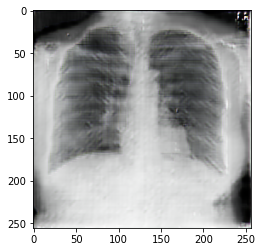

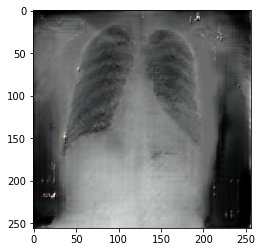

In [6]:
criar_imagens("Normal", 294)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256, 256, 8)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256, 256, 8)       0         
_________________________________________________________________
average_pooling2d_12 (Averag (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_20 (Batc (None, 128, 128, 16)    

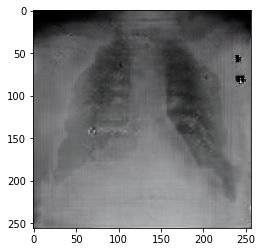

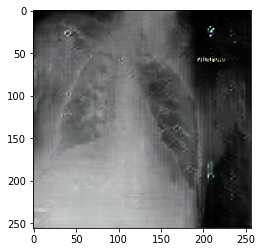

In [7]:
criar_imagens("Pneumonia", 265)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_3 (GaussianNo (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 256, 256, 8)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 256, 256, 8)       0         
_________________________________________________________________
average_pooling2d_18 (Averag (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_30 (Batc (None, 128, 128, 16)    

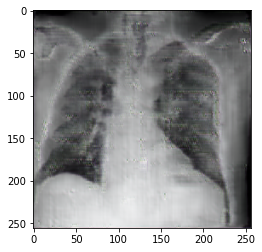

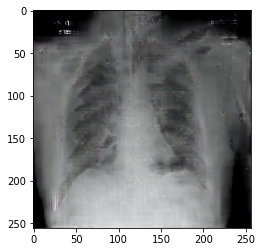

In [8]:
criar_imagens("COVID-19", 254)